In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from lab3_tools import loadAudio, path2info
from lab3_proto import words2phones, forcedAlignment

from lab_1_proto import mfcc

from prondict import prondict
from lab2_proto import concatHMMs

In [2]:
tidigits_path = "/home/tim/School/Speech_and_speaker_recognition/labs/tidigits/"

In [3]:
def my_frames2trans(symbols, outfilename, frameshift=0.01):
    """Writes a tab-separated .lab file for Audacity label track import."""
    with open(outfilename, 'w') as f:
        prev_label = symbols[0]
        start = 0
        for i, label in enumerate(symbols + ['<END>']):
            if label != prev_label:
                start_time = start * frameshift
                end_time = i * frameshift
                f.write(f"{start_time:.6f}\t{end_time:.6f}\t{prev_label}\n")
                start = i
                prev_label = label

## 4 Preparing the Data for DNN Training

### 4.1 Target Class Definition

In [4]:
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [5]:
phones = sorted(phoneHMMs.keys())
phones

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [6]:
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
nstates

{'ah': 3,
 'ao': 3,
 'ay': 3,
 'eh': 3,
 'ey': 3,
 'f': 3,
 'ih': 3,
 'iy': 3,
 'k': 3,
 'n': 3,
 'ow': 3,
 'r': 3,
 's': 3,
 'sil': 3,
 'sp': 1,
 't': 3,
 'th': 3,
 'uw': 3,
 'v': 3,
 'w': 3,
 'z': 3}

In [7]:
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
stateList[:10]

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0']

In [8]:
stateList.index('ay_2')

8

### 4.2 Forced Alignment

### Inspect Example

In [9]:
example = np.load('lab3_example.npz', allow_pickle=True)["example"].item()

In [10]:
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

In [11]:
example["filename"]

'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'

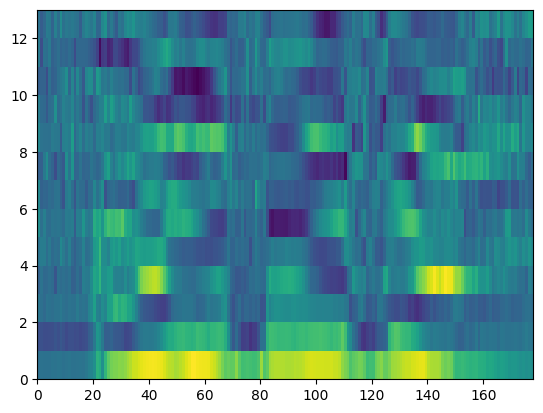

In [12]:
plt.pcolormesh(example["lmfcc"].T, shading='auto')

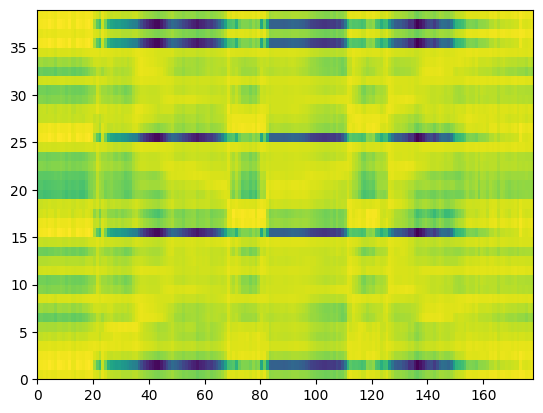

In [13]:
plt.pcolormesh(example["obsloglik"].T, shading='auto')

In [14]:
example["phoneTrans"]

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [15]:
len(example["phoneTrans"])

15

In [16]:
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

In [17]:
example["viterbiStateTrans"]

['sil_0',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_2',
 'z_0',
 'z_0',
 'z_0',
 'z_0',
 'z_1',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_1',
 'iy_2',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'f_0',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_2',
 'ao_0',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'th_0',


In [18]:
my_frames2trans(example["viterbiStateTrans"], 'example.lab')

In [19]:
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

### Load data fram TIDIGITS

In [20]:
filename = os.path.join(tidigits_path, "disc_4.1.1/tidigits/train/man/nw/z43a.wav")
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)

In [21]:
np.allclose(example['samples'], samples)

True

In [22]:
print("Example LMFCC:", example['lmfcc'].shape, np.mean(example['lmfcc']), np.std(example['lmfcc']))
print("Your LMFCC   :", lmfcc.shape, np.mean(lmfcc), np.std(lmfcc))

Example LMFCC: (178, 13) 54.11437325406732 241.07017352649078
Your LMFCC   : (178, 13) 54.11437325406732 241.07017352649078


In [23]:
print(np.allclose(example['lmfcc'], lmfcc))

True


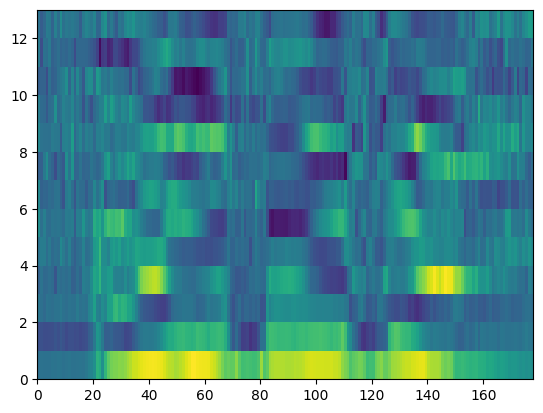

In [24]:
plt.pcolormesh(lmfcc.T, shading='auto')

Now, use the file name, and possibly the path2info function described in Section 3, to recover
the sequence of digits (word level transcription) in the file

In [25]:
wordTrans = list(path2info(filename)[2])
wordTrans

['z', '4', '3']

In [26]:
phoneTrans = words2phones(wordTrans, prondict, addSilence=True, addShortPause=True)

In [27]:
phoneTrans == example['phoneTrans']

True

In [28]:
len(phoneTrans)

15

In [29]:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
utteranceHMM.keys()

dict_keys(['startprob', 'transmat', 'means', 'covars', 'name'])

In [30]:
example['utteranceHMM']['means'].shape

(39, 13)

In [31]:
utteranceHMM['means'].shape

(39, 13)

In [32]:
example['utteranceHMM']['transmat'].shape

(40, 40)

In [33]:
utteranceHMM["transmat"].shape

(40, 40)

In [34]:
for i in example['utteranceHMM'].keys():
    print(i)
    print(np.allclose(utteranceHMM[i], example['utteranceHMM'][i]))
    print(np.mean(utteranceHMM[i]), np.std(utteranceHMM[i]))
    print(np.mean(example['utteranceHMM'][i]), np.std(example['utteranceHMM'][i]))

startprob
True
0.025 0.15612494995995996
0.025 0.15612494995995996
transmat
True
0.02499999972591728 0.12586619505136956
0.02499999972591728 0.12586619505136956
means
True
52.61744409964498 200.43236079453723
52.61744409964498 200.43236079453723
covars
True
20422.56236489152 13441.983589716345
20422.56236489152 13441.983589716345


In [35]:
import numpy as np

# Assuming:
# - `my_transmat` is your matrix
# - `ref_transmat` is example['utteranceHMM']['transmat']

# 1. Compute absolute differences
diff_matrix = np.abs(utteranceHMM["transmat"] - example['utteranceHMM']['transmat'])

# 2. Get locations where the difference is significant
threshold = 1e-6  # Tolerance for floating point differences
diff_indices = np.argwhere(diff_matrix > threshold)

# 3. Print details of the differences
for i, j in diff_indices:
    print(f"Diff at ({i},{j}): yours={utteranceHMM['transmat'][i][j]:.6f}, ref={example['utteranceHMM']['transmat'][i][j]:.6f}")


In [36]:
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
stateTrans

['sil_0',
 'sil_1',
 'sil_2',
 'z_0',
 'z_1',
 'z_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'r_0',
 'r_1',
 'r_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'sp_0',
 'f_0',
 'f_1',
 'f_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'r_0',
 'r_1',
 'r_2',
 'sp_0',
 'th_0',
 'th_1',
 'th_2',
 'r_0',
 'r_1',
 'r_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'sp_0',
 'sil_0',
 'sil_1',
 'sil_2']

In [37]:
stateTrans[10]

'r_1'

In [38]:
len(stateTrans)

39

In [39]:
from lab2_tools import log_multivariate_normal_density_diag

obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])

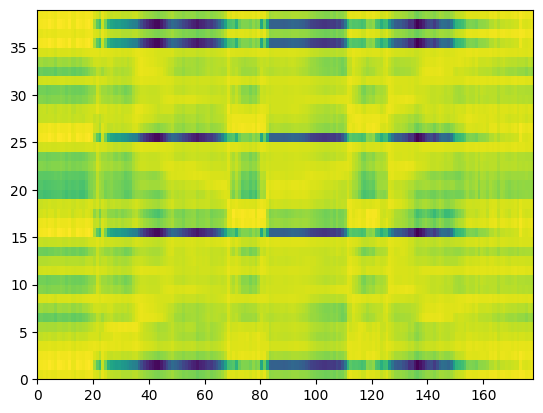

In [40]:
plt.pcolormesh(obsloglik.T, shading='auto')

In [41]:
print(np.allclose(obsloglik, example['obsloglik']))
print(np.allclose(utteranceHMM['transmat'], example['utteranceHMM']['transmat']))
print(np.allclose(utteranceHMM['means'], example['utteranceHMM']['means']))

True
True
True


In [42]:
from lab2_proto import viterbi

viterbi_loglik, viterbi_path = (
    viterbi(obsloglik,
            np.log(utteranceHMM['startprob']),
            np.log(utteranceHMM['transmat']))
)

/tmp/ipykernel_37450/2401149911.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
/tmp/ipykernel_37450/2401149911.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']))


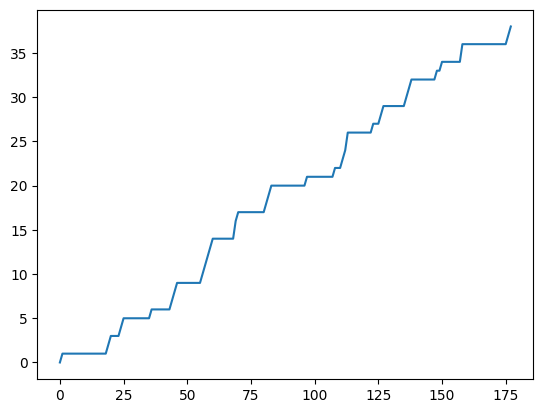

In [43]:
plt.plot(np.arange(len(viterbi_path)), viterbi_path)

In [44]:
example["viterbiPath"] == viterbi_path

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [45]:
viterbiStateTrans = [stateTrans[state_id] for state_id in viterbi_path]
viterbiStateTrans

['sil_0',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_2',
 'z_0',
 'z_0',
 'z_0',
 'z_0',
 'z_1',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_1',
 'iy_2',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'f_0',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_2',
 'ao_0',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'th_0',


In [46]:
len(viterbiStateTrans)

178

In [47]:
from lab3_tools import frames2trans

frames2trans(viterbiStateTrans, outfilename='z43a.lab')

'0 0.01 sil_0\n0.01 0.19000000000000003 sil_1\n0.19000000000000003 0.20000000000000004 sil_2\n0.20000000000000004 0.24000000000000007 z_0\n0.24000000000000007 0.25000000000000006 z_1\n0.25000000000000006 0.36000000000000015 z_2\n0.36000000000000015 0.4400000000000002 iy_0\n0.4400000000000002 0.45000000000000023 iy_1\n0.45000000000000023 0.46000000000000024 iy_2\n0.46000000000000024 0.5600000000000003 r_0\n0.5600000000000003 0.5700000000000003 r_1\n0.5700000000000003 0.5800000000000003 r_2\n0.5800000000000003 0.5900000000000003 ow_0\n0.5900000000000003 0.6000000000000003 ow_1\n0.6000000000000003 0.6900000000000004 ow_2\n0.6900000000000004 0.7000000000000004 f_0\n0.7000000000000004 0.8100000000000005 f_1\n0.8100000000000005 0.8200000000000005 f_2\n0.8200000000000005 0.8300000000000005 ao_0\n0.8300000000000005 0.9700000000000006 ao_1\n0.9700000000000006 1.0800000000000007 ao_2\n1.0800000000000007 1.1100000000000008 r_0\n1.1100000000000008 1.1200000000000008 r_1\n1.1200000000000008 1.13000

In [48]:
my_frames2trans(viterbiStateTrans, 'z43a.lab')

In [51]:
fa = forcedAlignment(lmfcc, phoneHMMs, phoneTrans, nstates)
my_frames2trans(fa, outfilename='z43a.lab')